## sequence is adding layers from pool with negative loss learning signal

In [92]:
import os
import math
import copy 
import random
import datetime
from collections import defaultdict
from enum import Enum
import json
import numpy as np 
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import gymnasium
from typing import (
    Type,
    List,
    Tuple,
)
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO
import wandb
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science','ieee', 'notebook', 'bright'])
plt.rcParams.update({'figure.dpi': '75'})

In [93]:
torch.cuda.is_available()

True

## config

In [94]:
default_config = {
    'seed' : 41,
    'device' : 'cuda',
    'wandb_run' : '',
    'n_runs' : 1,
    'epochs' : 1,
    'timesteps' : 100,
    'n_x' : 100,
    'n_tasks' : 3,
    'task_min_loss' : defaultdict(lambda: float('inf')),
    'task_max_loss' : defaultdict(lambda: -float('inf')),
    'in_features' : 1,
    'out_features' : 1,
    'n_pool_hidden_layers' : 10,
    'n_hidden_layers_per_network' : 3,
    'n_layers_per_network' : 5,
    'n_nodes_per_layer' : 40,
    'pool_layer_type' : torch.nn.Linear,
    'batch_size' : 32,
    'learning_rate' : 0.005,
    'discount_factor' : 0.95,
    'action_cache_size' : 5,
    'loss_fn' : torch.nn.MSELoss(),
    'sb3_model' : 'PPO',
    'sb3_policy' : 'MlpPolicy',
    'data_dir' : 'data',
    }
config = default_config
config['n_pool_hidden_layers'] = config['n_tasks'] * config['n_hidden_layers_per_network']
config

{'seed': 41,
 'device': 'cuda',
 'wandb_run': '',
 'n_runs': 1,
 'epochs': 1,
 'timesteps': 100,
 'n_x': 100,
 'n_tasks': 3,
 'task_min_loss': defaultdict(<function __main__.<lambda>()>, {}),
 'task_max_loss': defaultdict(<function __main__.<lambda>()>, {}),
 'in_features': 1,
 'out_features': 1,
 'n_pool_hidden_layers': 9,
 'n_hidden_layers_per_network': 3,
 'n_layers_per_network': 5,
 'n_nodes_per_layer': 40,
 'pool_layer_type': torch.nn.modules.linear.Linear,
 'batch_size': 32,
 'learning_rate': 0.005,
 'discount_factor': 0.95,
 'action_cache_size': 5,
 'loss_fn': MSELoss(),
 'sb3_model': 'PPO',
 'sb3_policy': 'MlpPolicy',
 'data_dir': 'data'}

### regression
sinusoidal curve regression as in MAML 2018 paper

In [95]:
lower_bound = torch.tensor(-5).float()
upper_bound = torch.tensor(5).float()
X = np.linspace(lower_bound, upper_bound, config['n_x'])
amplitude_range = torch.tensor([0.1, 5.0]).float()
phase_range = torch.tensor([0, math.pi]).float()
amps = torch.from_numpy(np.linspace(amplitude_range[0], amplitude_range[1], config['n_tasks'])).float()
phases = torch.from_numpy(np.linspace(phase_range[0], phase_range[1], config['n_tasks'])).float()
tasks_data = torch.tensor(np.array([ 
        X
        for _ in range(config['n_tasks'])
        ])).float()
tasks_targets = torch.tensor(np.array([
        [((a * np.sin(x)) + p).float()
        for x in X] 
        for a, p in zip(amps, phases)
        ])).float()
tasks_info = [
        {'i' : i, 
         'amp' : a, 
         'phase_shift' : p, 
         'lower_bound' : lower_bound, 
         'upper_bound' : upper_bound, 
         'amplitude_range_lower_bound' : amplitude_range[0], 
         'amplitude_range_upper_bound' : amplitude_range[1], 
         'phase_range_lower_bound' : phase_range[0],
         'phase_range_lower_bound' : phase_range[1]}
        for i, (a, p) in enumerate(zip(amps, phases))
]
print(f'[INFO] Tasks created.')

[INFO] Tasks created.


In [96]:
print(tasks_data.shape)
print(tasks_data.dtype)
print(tasks_targets.shape)
print(tasks_targets.dtype)
print(len(tasks_info))
print(len(tasks_info[0]))

torch.Size([3, 100])
torch.float32
torch.Size([3, 100])
torch.float32
3
8


In [97]:
class RegressionModel(torch.nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(config['in_features'], config['n_nodes_per_layer']),  
            torch.nn.Linear(config['n_nodes_per_layer'], config['n_nodes_per_layer']), 
            torch.nn.Linear(config['n_nodes_per_layer'], config['out_features'])  
        ])

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = torch.nn.functional.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x

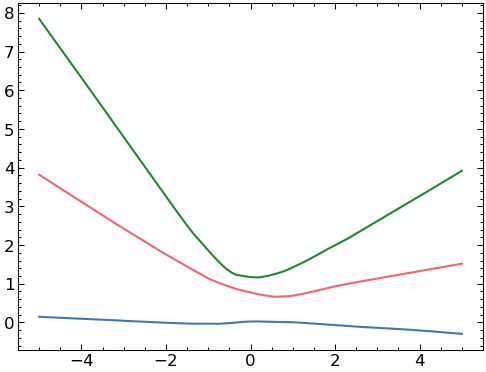

In [77]:
data = []
for x, y in zip(tasks_data, tasks_targets):
    data.append([x,y])
for i, (x, y) in enumerate(data):
    model = RegressionModel()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    num_epochs = 10
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad() 
        outputs = model(x.view(-1, 1))
        loss = criterion(outputs, y.view(-1,1))
        loss.backward()
        optimizer.step()
    yhats = model(x.view(-1, 1))
    plt.plot(x, [yhat.detach().numpy() for yhat in yhats])

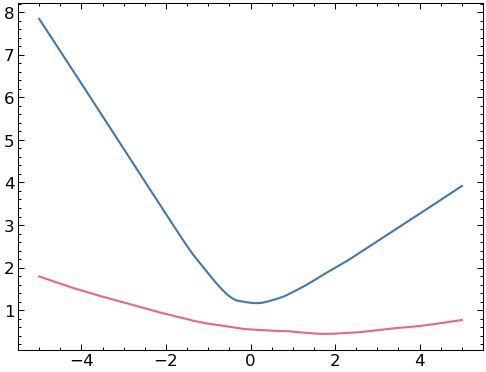

In [78]:
# experiment: replace initial and final layers with xavier initialized layers
new_initial = torch.nn.Linear(in_features=1, out_features=config['n_nodes_per_layer'])
new_final = torch.nn.Linear(in_features=config['n_nodes_per_layer'], out_features=1)
torch.nn.init.xavier_uniform_(new_initial.weight)
torch.nn.init.xavier_uniform_(new_final.weight)

yhats = model(x.view(-1, 1))
plt.plot(x, [yhat.detach().numpy() for yhat in yhats])

model_copy = copy.deepcopy(model)
model_copy.layers[0] = new_initial
model_copy.layers.pop(-1)
model_copy.layers.append(new_final)

yhats = model_copy(x.view(-1, 1))
plt.plot(x, [yhat.detach().numpy() for yhat in yhats]);

In [98]:
class LayerPool:
    def __init__(self, 
                layer_constructor: Type[torch.nn.Linear]=config['pool_layer_type'],
                in_features: int=config['in_features'],
                out_features: int=config['out_features'],
                num_nodes_per_layer: int=config['n_nodes_per_layer'],
                layers: List[torch.nn.Linear]=None):
        self.layer_constructor = layer_constructor
        self.in_features = in_features
        self.out_features = out_features
        self.num_nodes_per_layer = num_nodes_per_layer

        if layers is None:
            self.layers = [self.layer_constructor(in_features=num_nodes_per_layer, out_features=num_nodes_per_layer)for _ in range(config['n_pool_hidden_layers'])]
            for _ in range(config['n_tasks']):
                self.layers.append(self.layer_constructor(in_features=in_features, out_features=num_nodes_per_layer))
                self.layers.append(self.layer_constructor(in_features=num_nodes_per_layer, out_features=out_features))
            [torch.nn.init.xavier_uniform_(layer.weight) for layer in self.layers]
        else:
            self.layers = layers
            config['n_pool_hidden_layers'] = len(self.layers)

        self.initial_input_layer = copy.deepcopy(random.choice([layer for layer in self.layers if layer.in_features==1]))
        self.initial_output_layer = copy.deepcopy(random.choice([layer for layer in self.layers if layer.out_features==1]))
        
    def __str__(self) -> str:
        return f"LayerPool(size={self.size}, layer_type={config['pool_layer_type']}, num_nodes_per_layer={config['n_nodes_per_layer']}"


In [99]:
class InnerNetworkAction(Enum):
    # no action is 0 to prevent multiplication
    # by 0 in building s prime with the past n
    # action enum values
    ADD = 1
    ERROR = 2

In [100]:
class InnerNetworkTask(Dataset):
    def __init__(self, data, targets, info):
        self.data = data 
        self.targets = targets
        self.info = info

    def __len__(self):
        assert len(self.data) == config['n_x'], '[ERROR] Length should be the same as n_x.'
        return len(self.data)

    def __getitem__(self, index):
        assert self.data[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.data[index].dtype}'
        assert self.targets[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.targets[index].dtype}'
        sample = {
            'x' : self.data[index],
            'y' : self.targets[index],
            'info' : self.info
        }
        return sample
    
    def __str__(self):
        return f'[INFO] InnerNetworkTask(data={self.data}, targets={self.targets}, info={self.info})'

In [114]:
class InnerNetwork(gymnasium.Env, torch.nn.Module):
    def __init__(self, 
                task: InnerNetworkTask,
                layer_pool: LayerPool,
                calibration: bool=False,
                epoch: int=0,
                in_features: int=config['in_features'],
                out_features: int=config['out_features'],
                learning_rate: float=config['learning_rate'],
                batch_size: int=config['batch_size'],
                action_cache_size: float=config['action_cache_size'],
                shuffle: bool=True,
                ):
        super(InnerNetwork, self).__init__()
        self.epoch = epoch
        self.task = task
        self.layer_pool = layer_pool
        self.calibration = calibration
        self.in_features = in_features
        self.out_features = out_features
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.action_cache_size = action_cache_size
        print(config['task_max_loss'])
        print(config['task_min_loss'])
        self.task_max_loss = config['task_max_loss'][self.task.info['i']]
        self.task_min_loss = config['task_min_loss'][self.task.info['i']]
        self.local_max_loss = -float('inf')
        self.local_min_loss = float('inf')

        self.prev = defaultdict(lambda: None)
        self.curr = defaultdict(lambda: None)
        self.data_loader = DataLoader(task, batch_size=batch_size, shuffle=shuffle)
        self.data_iter = iter(self.data_loader)
       
        # initial input and output layers to allow state calculation to get actions. these layers
        # are then replaced by the outer network. the objective of the outer network is to find
        # the best layers for a neural network (that means not just selecting the hidden layers).
        # the same hidden layers produce drastically different results with different input and output
        # layers 
        self.initial_input_layer = layer_pool.initial_input_layer
        self.initial_output_layer = layer_pool.initial_output_layer
        self.layers = torch.nn.ModuleList([self.initial_input_layer, self.initial_output_layer]) 
        self.layers_pool_indices = [] 
        self.actions_taken = []
        self.loss_fn = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate)

        self.timestep = 0
        self.loss_vals = []
        self.reward_vals = []
        self.errors = 0

        self.train()
        self.next_batch()
        self.train_inner_network()
        self.observation_space = gymnasium.spaces.box.Box(low=float('-inf'), high=float('inf'), shape=self.build_state().shape)
        self.action_space = gymnasium.spaces.discrete.Discrete(len(self.layer_pool.layers))

    def step(self, action: np.int64) -> Tuple[torch.Tensor, float, bool, dict]: 
        assert action.shape == (), f'[ERROR] Expected action shape () for scalar {self.action_space.n}, got: {action.shape}'
        assert action.dtype == np.int64, f'[ERROR] Expected np.int64 dtype, got: {action.dtype}'

        self.timestep += 1
        self.prev = self.curr
        self.curr = defaultdict(lambda: None)
        self.next_batch()
        self.update(action)
        termination = False if len(self.layers)<config['n_layers_per_network'] else True
        if termination:
            self.train_inner_network()
        else:
            self.forward()

        # calibration is finding the min and max loss values for the task to
        # scale the loss (and the reward) between 0 and 1 across tasks
        if self.calibration==True:
            self.task_max_loss = max(self.curr['loss'], self.task_max_loss)
            self.task_min_loss = min(self.curr['loss'], self.task_min_loss) 
        self.local_max_loss = max(self.curr['loss'], self.local_max_loss)
        self.local_min_loss = min(self.curr['loss'], self.local_min_loss) 
        
        s_prime = self.build_state()
        reward = self.reward()
        self.log()

        # update pool
        # TODO is trying to update the pool right after layers are trained. with
        # each episode then the inner network will use increasingly trained layers
        # what could also happen is noise
        for index, layer in zip(self.layers_pool_indices, self.layers[1:-1]):
            self.layer_pool.layers[index] = layer

        return (
            s_prime,
            reward, 
            termination,
            False,
            {}
        )

    def next_batch(self, throw_exception=False) -> None:
        if (throw_exception):
            batch = next(self.data_iter)
            self.curr['x'] = batch['x'].view(-1, 1)
            self.curr['y'] = batch['y'].view(-1, 1)
            self.curr['info'] = batch['info']
        else: 
            try:
                batch = next(self.data_iter)
            except StopIteration:
                self.data_loader = DataLoader(self.task, batch_size=self.batch_size, shuffle=self.shuffle)
                self.data_iter = iter(self.data_loader)
                batch = next(self.data_iter)
            finally:
                self.curr['x'] = batch['x'].view(-1, 1)
                self.curr['y'] = batch['y'].view(-1, 1)
                self.curr['info'] = batch['info']
    
    def update(self, action: np.int64) -> None:
        new_layer = self.layer_pool.layers[action]
        
        # first step and input layer and not already in network
        if self.timestep==1 \
            and new_layer.in_features==1 \
            and new_layer not in self.layers:
            
            self.layers[0] = new_layer
            self.curr['action_type'] = InnerNetworkAction.ADD
        # last step and output layer and not already in network
        elif self.timestep==2 \
            and new_layer.out_features==1 \
            and new_layer not in self.layers:

            self.layers[-1] = new_layer
            self.curr['action_type'] = InnerNetworkAction.ADD
        # not first or last step and hidden layer and not already in network
        elif self.timestep!=1 \
            and self.timestep!=2 \
            and new_layer not in self.layers \
            and new_layer.in_features!=1 \
            and new_layer.out_features!=1 \
            and len(self.layers) < config['n_layers_per_network']: 

            final_layer = self.layers.pop(-1) 
            self.layers.append(new_layer)
            self.layers.append(final_layer) 
            self.layers_pool_indices.append(torch.tensor(action))
            self.curr['action_type'] = InnerNetworkAction.ADD
        else: 
            self.curr['action_type'] = InnerNetworkAction.ERROR
            
    def forward(self) -> None:
        x = copy.deepcopy(self.curr['x'])
        for i in range(len(self.layers) - 1): 
            x = torch.nn.functional.relu(self.layers[i](x))
        self.curr['latent_space'] = x
        self.curr['y_hat'] = self.layers[-1](x) 
        self.curr['loss'] = self.loss_fn(self.curr['y'], self.curr['y_hat'])
        self.curr['loss'].backward()
    
    def train_inner_network(self) -> None: 
        for _ in range(10):
            self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate) 
            self.opt.zero_grad()
            self.forward()
            self.opt.step()
            self.next_batch()
    
    def build_state(self) -> np.ndarray:
        task_info = torch.tensor([self.task.info['amp'], self.task.info['phase_shift']]).squeeze()
        loss = torch.Tensor([self.curr['loss']])
        yhat_scale = torch.Tensor([torch.Tensor(torch.max(torch.abs(self.curr['y_hat']))).detach().item()])
        one_hot_layers = torch.tensor(np.array([1 if self.layer_pool.layers[i] in self.layers else 0 for i in range(len(self.layer_pool.layers))]))
        layer_indices = [index + 1 for index in self.layers_pool_indices.copy()] # 0 bump by 1 to avoid 0th index layer being 0 since padding 0s too
        while len(layer_indices) < config['n_layers_per_network']:
            layer_indices.insert(0, 0)
        layer_indices = torch.tensor(layer_indices)
        return torch.concat((
            task_info,
            yhat_scale,
            layer_indices,
            one_hot_layers,
            loss,
        ), dim=0).detach().numpy()
    
    def reward(self) -> torch.Tensor:
        # min-max scaled reward is negative loss of inner network multiplied 
        # by a scale factor that is "how bad" initial layers chosen are to 
        # credit those early actions more in the return

        if self.calibration:
            scale_factor = 1
        else:
            # "how bad" the initial layers are is a function of their loss 
            # versus the min and max loss seen for task to ensure that credit 
            # assignment skews towards ADD rather than TRAIN actions (because 
            # Adam optimizer can train any set of layers to good performance 
            # in few steps, but that's not the learning objective) 
            # e.g., with max loss for task=14, 
            # max loss for task=12, reduce each reward with a factor of 
            # 0.14 <- 14-12/14 = 2/14 = 0.14
            scale_factor = ((self.task_max_loss - self.local_max_loss) / self.task_max_loss) 

        if (self.curr['action_type'] == InnerNetworkAction.ERROR):
            reward = torch.tensor(-1)
        else:
            epsilon = 1e-8 # prevent division by zero
            reward = - (((self.curr['loss'] - self.task_min_loss + epsilon) / (self.task_max_loss - self.task_min_loss + epsilon)))
            reward = scale_factor * reward
        
        self.curr['reward'] = reward
        return reward

    def log(self):
        task_num = str(self.task.info['i'])
        self.loss_vals.append(copy.copy(self.curr['loss'].item()))
        self.reward_vals.append(copy.copy(self.curr['reward'].item()))
        self.errors = self.errors + 1 if self.curr['action_type']==InnerNetworkAction.ERROR else self.errors
        wandb.log({ f'loss_task{task_num}_per_step' : self.curr['loss']})
        wandb.log({ f'reward_task{task_num}_per_step' : self.curr['reward']})
        wandb.log({ f'action_types_task{task_num}_per_step' : wandb.Histogram(torch.tensor([self.actions_taken]))})
        wandb.log({ f'pool_indices_task{task_num}_per_step' : wandb.Histogram(torch.tensor(self.layers_pool_indices))})

    def reset(self, seed=None) -> np.ndarray:
        # print(f"[INFO] Reset at timestep={self.timestep}, layers={self.layers_pool_indices}")
        self.timestep = 0
        self.prev = defaultdict(lambda: None)
        self.curr = defaultdict(lambda: None)
        self.initial_input_layer = copy.deepcopy(random.choice([layer for layer in self.layer_pool.layers if layer.in_features==1]))
        self.initial_output_layer = copy.deepcopy(random.choice([layer for layer in self.layer_pool.layers if layer.out_features==1]))
        self.layers = torch.nn.ModuleList([self.initial_input_layer, self.initial_output_layer]) 
        self.layers_pool_indices = [] 
        self.loss_fn = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate)
        self.actions_taken = []
        self.loss_vals = []
        self.reward_vals = []
        # TODO is to try reseting local max and min losees at the episode level and not
        # just at the epoch level as is now
        # self.local_max_loss = None
        # self.local_min_loss = None

        self.train()
        self.next_batch()
        self.train_inner_network()
        return self.build_state(), None

In [118]:
class REML:
    def __init__(
        self,
        layer_pool: LayerPool,
        tasks: List[InnerNetworkTask],
        path: str,
        run: int=1,
        model=config['sb3_model'],
        policy=config['sb3_policy'],
        epochs: int=config['epochs'],
        timesteps: int=config['timesteps'],
        ):
        self.layer_pool = layer_pool
        self.tasks = tasks
        self.path=path
        if config['sb3_model']=='PPO':
            model = PPO
        elif config['sb3_model']=='RecurrentPPO':
            model = RecurrentPPO
        dummy_env = self.make_env(tasks[0], layer_pool)
        self.run = run
        self.model = model(policy, dummy_env)
        self.policy = policy
        self.epochs = epochs
        self.timesteps = timesteps
        self.return_epochs = defaultdict(lambda: [])
        self.cumuloss_epochs = defaultdict(lambda: [])
        self.errors_epochs = defaultdict(lambda: [])

    def __str__(self) -> str:
        return f'REML(model={self.model}, policy={self.policy})'
    
    def make_env(self, task, epoch=None, calibration=False) -> gymnasium.Env:
        return gymnasium.wrappers.NormalizeObservation(InnerNetwork(task, self.layer_pool, epoch=epoch, calibration=calibration))
    
    def calibrate(self):
        # get the min and max loss per task to min-max
        # scale across tasks so no one task dominates learning
        # based on the magnitude of the loss (and reward) signal
        for i, task in enumerate(self.tasks): 
            print(f'[INFO] Calculating min and max loss for task {i+1}.')
            self.env = self.make_env(task, calibration=True)
            self.model.set_env(self.env)
            self.model.learn(total_timesteps=self.timesteps)

            # update min and max loss 
            config['task_min_loss'][task.info['i']] = min(self.env.task_min_loss, config['task_min_loss'][task.info['i']])
            config['task_max_loss'][task.info['i']] = max(self.env.task_max_loss, config['task_max_loss'][task.info['i']])
    
    def train(self):
        # wraps stablebaselines3 learn() so we call it n * m times
        # n is the number of epochs where we run all m tasks
        # we use the same policy, swapping out envs for the n tasks, m times. 

        self.calibrate()

        # to calculate variance
        # e.g., task: [ n: [epoch: [100 values]] ] / array with n rows, epoch columns 
        # where cell @ [nth run][mth epoch] is cumulative loss/reward
        for epoch in range(self.epochs):
            print(f'[INFO] Epoch={epoch+1}/{self.epochs}')
            for i, task in enumerate(self.tasks): 
                print(f'[INFO] Task={i+1}/{len(self.tasks)}')

                # each task gets its own network
                self.task = task 
                self.env = self.make_env(task, epoch=epoch)
                self.model.set_env(self.env)
                self.model.learn(total_timesteps=self.timesteps)
                
                # update min and max loss for task
                local_min_loss = self.env.local_min_loss
                local_max_loss = self.env.local_max_loss
                config['task_min_loss'][self.task.info['i']] = min(local_min_loss, config['task_min_loss'][self.task.info['i']])
                config['task_max_loss'][self.task.info['i']] = max(local_max_loss, config['task_max_loss'][self.task.info['i']])

                # track reward and loss for plots
                # track reward and loss for plots
                self.return_epochs[str(self.task.info['i'])].append(sum(self.env.reward_vals))
                self.cumuloss_epochs[str(self.task.info['i'])].append(sum(self.env.loss_vals))
                self.errors_epochs[str(self.task.info['i'])].append(self.env.errors)

                # log to wandb
                wandb.log({ f'errors_run{self.run}_task{i}_per_epoch' : self.env.errors })
                wandb.log({ f'cumulative_reward_run{self.run}_task{i}_per_epoch' : sum(self.env.reward_vals) })
                wandb.log({ f'cumulative_loss_run{self.run}_task{i}_per_epoch' : sum(self.env.loss_vals) })
                wandb.log({ f'pool_indices_run{self.run}_task{i}_per_epoch' : wandb.Histogram(torch.tensor(self.env.layers_pool_indices))})

                plot_sine_curves(self, tasks=[self.task], path=self.path, epoch=epoch, image=True)

### testing

In [45]:
config['wandb_run'] = ''
wandb.init(
    project='reinforcement-meta-learning',
    config=config,
    name=config['wandb_run']
)

cumulative_loss_run1_task0_per_epoch,▁
cumulative_loss_run1_task1_per_epoch,▁
cumulative_reward_run1_task0_per_epoch,▁
cumulative_reward_run1_task1_per_epoch,▁
errors_run1_task0_per_epoch,▁
errors_run1_task1_per_epoch,▁
loss_task0_per_step,▁▂▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▃▁▁█▄▂▂▁▁▁▃▁▄▃▁▁▁▇▁▁▁▁
loss_task2_per_step,▅▆▄▄▇▅▄▇▃▄▄▅▄▄▅▂▂▃▄▆▆▄█▃▂▃▅▅▃▄▃▂▄▇▅▂▁▄▁▁
reward_task0_per_step,▃▁▁▃▁▁▁▁▁▃▁▁▃▁▃▃▃▁▁▁▁▁█▁▁▁▁▄▁▁▁▁▃▁▁▁▁▁▁▁
reward_task2_per_step,▁▁▁▁▁▅▆▅▇▁▁▁▁▇▆█▇▇▆▁▇█▁██▁▁█▁███▁▁▁██▁▁▁
cumulative_loss_run1_task0_per_epoch,3.78681


In [119]:
tasks = [InnerNetworkTask(data=tasks_data[i], targets=tasks_targets[i], info=tasks_info[i]) for i in range(config['n_tasks'])]
eval_task = random.choice(list(tasks))
training_tasks = list(set(tasks) - {eval_task})
pool = LayerPool()

In [120]:
return_task_runbyepoch = defaultdict(lambda: [])
cumuloss_task_runbyepoch = defaultdict(lambda: [])
errors_task_runbyepoch = defaultdict(lambda: [])
data_paths = []
model_param_paths = []

for n in range(1, config['n_runs']+1):     
    print(f"[INFO] n={n}")

    # paths
    data_path = f"{config['data_dir']}/{config['sb3_model']}_{datetime.datetime.now().strftime('%H-%M')}"
    model_path = data_path.split('/', 1)[-1]
    os.makedirs(data_path, exist_ok=True)
    data_paths.append(data_path)
    model_param_paths.append(model_path)

    # train reml
    reml = REML(tasks=training_tasks, layer_pool=pool, run=n, path=data_path)
    reml.train()

    # TODO: move below into a REML function
    # save model params
    reml.model.save(model_path)
    # save data
    for task in tasks:
        return_task_runbyepoch[str(task.info['i'])].append(reml.return_epochs[str(task.info['i'])])
        cumuloss_task_runbyepoch[str(task.info['i'])].append(reml.cumuloss_epochs[str(task.info['i'])])
        errors_task_runbyepoch[str(task.info['i'])].append(reml.errors_epochs[str(task.info['i'])])
    with open(f'{data_path}_returns', 'w') as json_file:
        json.dump(return_task_runbyepoch, json_file, indent=4)
    with open(f'{data_path}_cumuloss', 'w') as json_file:
        json.dump(cumuloss_task_runbyepoch, json_file, indent=4)
    with open(f'{data_path}_errors', 'w') as json_file:
        json.dump(errors_task_runbyepoch, json_file, indent=4)


[INFO] n=1
defaultdict(<function <lambda> at 0x000002AC7FF76340>, {2: tensor(109.3233, grad_fn=<MseLossBackward0>), 0: -inf, 1: tensor(43.9234, grad_fn=<MseLossBackward0>)})
defaultdict(<function <lambda> at 0x000002AC7E70B380>, {2: tensor(0.0837, grad_fn=<MseLossBackward0>), 0: inf, 1: tensor(0.0106, grad_fn=<MseLossBackward0>)})
[INFO] Calculating min and max loss for task 1.
defaultdict(<function <lambda> at 0x000002AC7FF76340>, {2: tensor(109.3233, grad_fn=<MseLossBackward0>), 0: -inf, 1: tensor(43.9234, grad_fn=<MseLossBackward0>)})
defaultdict(<function <lambda> at 0x000002AC7E70B380>, {2: tensor(0.0837, grad_fn=<MseLossBackward0>), 0: inf, 1: tensor(0.0106, grad_fn=<MseLossBackward0>)})
[INFO] Calculating min and max loss for task 2.
defaultdict(<function <lambda> at 0x000002AC7FF76340>, {2: tensor(109.3233, grad_fn=<MseLossBackward0>), 0: -inf, 1: tensor(43.9234, grad_fn=<MseLossBackward0>)})
defaultdict(<function <lambda> at 0x000002AC7E70B380>, {2: tensor(0.0837, grad_fn=<Mse

In [121]:
config

{'seed': 41,
 'device': 'cuda',
 'wandb_run': '',
 'n_runs': 1,
 'epochs': 1,
 'timesteps': 100,
 'n_x': 100,
 'n_tasks': 3,
 'task_min_loss': defaultdict(<function __main__.<lambda>()>,
             {2: tensor(0.0370, grad_fn=<MseLossBackward0>),
              0: inf,
              1: tensor(0.0106, grad_fn=<MseLossBackward0>)}),
 'task_max_loss': defaultdict(<function __main__.<lambda>()>,
             {2: tensor(109.3233, grad_fn=<MseLossBackward0>),
              0: -inf,
              1: tensor(43.9234, grad_fn=<MseLossBackward0>)}),
 'in_features': 1,
 'out_features': 1,
 'n_pool_hidden_layers': 9,
 'n_hidden_layers_per_network': 3,
 'n_layers_per_network': 5,
 'n_nodes_per_layer': 40,
 'pool_layer_type': torch.nn.modules.linear.Linear,
 'batch_size': 32,
 'learning_rate': 0.005,
 'discount_factor': 0.95,
 'action_cache_size': 5,
 'loss_fn': MSELoss(),
 'sb3_model': 'PPO',
 'sb3_policy': 'MlpPolicy',
 'data_dir': 'data'}

### plots

In [123]:
# plotting functions require loading reml parameters to new reml object
# e.g.,
#   reml = REML(layer_pool=pool, tasks=tasks)
#   reml.model.load('RecurrentPPO_12-37')

def plot_loss_vs_step_curves(reml,
                      tasks,
                      path,
                      steps=100,
                      image=False,
                      ) -> Tuple[dict]:

    meta_task_lossbystep = defaultdict(lambda: [])
    scratch_task_lossbystep = defaultdict(lambda: [])
    for task in tasks: 
        # get loss per step from meta-learned model
        env = reml.make_env(task)
        reml.model.set_env(env, force_reset=False)
        obs, _ = env.reset()
        while len(env.layers) < config['n_layers_per_network']:
            action, _ = reml.model.predict(obs)
            obs, _, _, _, _ = env.step(action)
        for _ in range(steps):
            action, _ = reml.model.predict(obs)
            obs, _, _, _, _ = env.step(action)
            meta_task_lossbystep[task].append(env.curr['loss'])

        # get loss per step from model trained from scratch 
        model = RegressionModel()
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        model.train()
        for _ in range(steps):
            optimizer.zero_grad() 
            outputs = model(task.data.view(-1, 1))
            loss = criterion(outputs, task.targets.view(-1,1))
            loss.backward()
            optimizer.step()
            scratch_task_lossbystep[task].append(loss)

        # plot loss vs step curve for each task
        plt.figure()
        plot_title = f"Loss versus step (task={task.info['i']+1})"
        plot_path = f'{path}/{plot_title}.png'  
        meta_label = "Meta-trained network"
        scratch_label = "Baseline trained from scratch"
        plt.plot(range(steps), [loss.detach().numpy() for loss in meta_task_lossbystep[task]], label=meta_label)
        plt.plot(range(steps), [loss.detach().numpy() for loss in scratch_task_lossbystep[task]], label=scratch_label)
        plt.xlabel("Timestep")
        plt.ylabel("MSE Loss")
        plt.title(plot_title)
        plt.legend()

        # save png / wandb
        if image:
            plt.savefig(plot_path)
            wandb.log({plot_title: wandb.Image(plot_path)})

    return meta_task_lossbystep, scratch_task_lossbystep

def plot_sine_curves(reml, 
                     tasks, 
                     path,
                     epoch=None, 
                     image=False, 
                     args=defaultdict()) -> dict:

    task_yhats = defaultdict(lambda: None)
    for task in tasks: 
        # set env
        env = reml.make_env(task)
        reml.model.set_env(env, force_reset=False)

        # build network in env
        obs, _ = env.reset()
        while len(env.layers)!=config['n_layers_per_network']:
            action, _ = reml.model.predict(obs)
            obs, _, _, _, _ = env.step(action)

        # run network to get yhats
        xs, ys = task.data.clone(), task.targets.clone()
        xs, ys = xs.view(len(xs), 1), ys.view(len(ys), 1)
        env.curr['x'] = xs
        env.curr['y'] = ys
        env.forward()
        yhats = env.curr['y_hat']

        # plot sine curve
        plt.figure()
        plot_title = f"Sine curve (epoch={epoch}, task={task.info['i']+1})" if epoch!=None else f"Sine curve (task={task.info['i']+1})"
        plot_path = f'{path}/{plot_title}.png'  
        plt.plot(task.data, [yhat.detach().numpy() for yhat in yhats], **args)
        plt.plot(task.data, task.targets, label='ground truth', linestyle='--')
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title(plot_title)
        plt.legend()

        # save png / wandb
        if image:
            plt.savefig(plot_path)
            wandb.log({plot_title: wandb.Image(plot_path)})

        # return if needed 
        xs, yhats = task.data, [yhat.detach().numpy() for yhat in yhats]
        task_yhats[task] = yhats
    return task_yhats

# def plot_few_shot_learning(reml,
#                            eval_task,
#                            k=5):

# def plot_reward_with_variance(reml, 
#                               reward_vals):
# holdout_task = 0
# task_mean = {}
# task_std = {}
# for i, task_values in enumerate(returns.values()):
#     if len(task_values[0])==holdout_task: continue
#     array = np.array(task_values)
#     assert np.ndim(array)==2, f"[ERROR] Expected ndim=2, got {np.ndim(array)}"
#     # rows are over n_runs, cols are epochs
#     task_mean[i] = [np.mean(array[:, epoch]) for epoch in range(array.shape[1])]
#     task_std[i] = [np.std(array[:, epoch]) for epoch in range(array.shape[1])] 
# print(task_mean)
# print(task_std)

# # plot mean and std return for 2 epochs
# for task_num in range(config['n_tasks']):
#     if task_num==holdout_task: continue
#     plt.figure(task_num)
#     plt.plot(range(len(task_mean[task_num])), task_mean[task_num], label='mean')
#     plt.fill_between(
#         range(len(task_mean[1])), 
#         [mean - std for mean, std in zip(task_mean[task_num], task_std[task_num])], 
#         [mean + std for mean, std in zip(task_mean[task_num], task_std[task_num])],
#         alpha=0.2, 
#         label='std');

# def plot_loss_with_variance
# holdout_task = 1
# task_mean = {}
# task_std = {}
# for i, task_values in enumerate(cumuloss.values()):
#     if len(task_values[0])==holdout_task: continue
#     array = np.array(task_values)
#     assert np.ndim(array)==2, f"[ERROR] Expected ndim=2, got {np.ndim(array)}"
#     # rows are over n_runs, cols are epochs
#     task_mean[i] = [np.mean(array[:, epoch]) for epoch in range(array.shape[1])]
#     task_std[i] = [np.std(array[:, epoch]) for epoch in range(array.shape[1])] 

# # plot mean and std return for 2 epochs
# for task_num in range(config['n_tasks']):
#     if task_num==holdout_task: continue
#     plt.figure(task_num)
#     plt.plot(range(len(task_mean[task_num])), task_mean[task_num], label='mean')
#     plt.fill_between(
#         range(len(task_mean[1])), 
#         [mean - std for mean, std in zip(task_mean[task_num], task_std[task_num])], 
#         [mean + std for mean, std in zip(task_mean[task_num], task_std[task_num])],
#         alpha=0.2, 
#         label='std');

# def plot_errors_with_variance

In [31]:
print(config['task_max_loss'])
print(config['task_min_loss'])

defaultdict(<function <lambda> at 0x000002AB63805760>, {<__main__.InnerNetworkTask object at 0x000002AB6DB4B510>: tensor(41.1404, grad_fn=<MseLossBackward0>), <__main__.InnerNetworkTask object at 0x000002AB6DA40D50>: tensor(75.3661, grad_fn=<MseLossBackward0>), <__main__.InnerNetworkTask object at 0x000002AB6DAB4590>: None})
defaultdict(<function <lambda> at 0x000002AB63805440>, {<__main__.InnerNetworkTask object at 0x000002AB6DB4B510>: tensor(0.0001, grad_fn=<MseLossBackward0>), <__main__.InnerNetworkTask object at 0x000002AB6DA40D50>: tensor(0.4617, grad_fn=<MseLossBackward0>), <__main__.InnerNetworkTask object at 0x000002AB6DAB4590>: None})


task used=[INFO] InnerNetworkTask(data=tensor([-5.0000, -4.8990, -4.7980, -4.6970, -4.5960, -4.4949, -4.3939, -4.2929,
        -4.1919, -4.0909, -3.9899, -3.8889, -3.7879, -3.6869, -3.5859, -3.4848,
        -3.3838, -3.2828, -3.1818, -3.0808, -2.9798, -2.8788, -2.7778, -2.6768,
        -2.5758, -2.4747, -2.3737, -2.2727, -2.1717, -2.0707, -1.9697, -1.8687,
        -1.7677, -1.6667, -1.5657, -1.4646, -1.3636, -1.2626, -1.1616, -1.0606,
        -0.9596, -0.8586, -0.7576, -0.6566, -0.5556, -0.4545, -0.3535, -0.2525,
        -0.1515, -0.0505,  0.0505,  0.1515,  0.2525,  0.3535,  0.4545,  0.5556,
         0.6566,  0.7576,  0.8586,  0.9596,  1.0606,  1.1616,  1.2626,  1.3636,
         1.4646,  1.5657,  1.6667,  1.7677,  1.8687,  1.9697,  2.0707,  2.1717,
         2.2727,  2.3737,  2.4747,  2.5758,  2.6768,  2.7778,  2.8788,  2.9798,
         3.0808,  3.1818,  3.2828,  3.3838,  3.4848,  3.5859,  3.6869,  3.7879,
         3.8889,  3.9899,  4.0909,  4.1919,  4.2929,  4.3939,  4.4949,  4.5960,
 

TypeError: unsupported operand type(s) for -: 'NoneType' and 'Tensor'

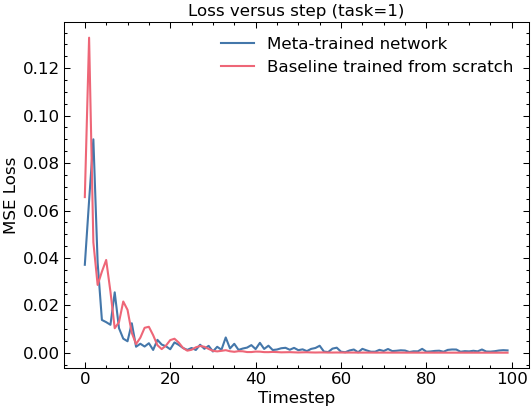

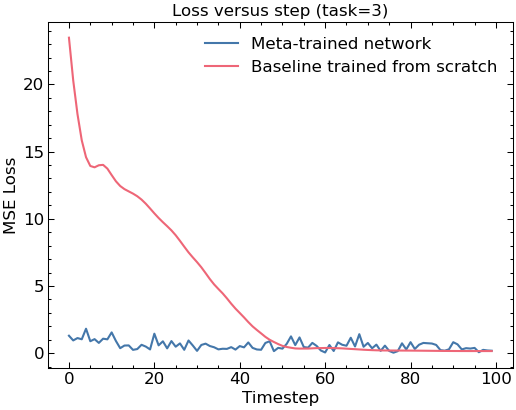

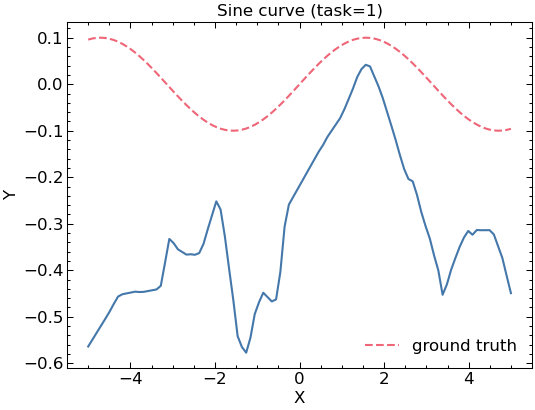

In [30]:
reml = REML(layer_pool=pool, tasks=tasks)
reml.model.load('PPO_16-47')
plot_loss_vs_step_curves(reml=reml, tasks=training_tasks, path=data_path)
plot_sine_curves(reml=reml, tasks=tasks, path=data_path)

#### few shot learning tests

k=5

In [243]:
# unseen task
# choose 5 and 10 datapoints on it, K = 5, K = 10
k = 5
k_pairs = torch.tensor(random.sample(list(zip(eval_task.data, eval_task.targets)), k))
print(len(k_pairs))
print(k_pairs)

# network still recieves the same 100 x values {-5, ..., 5}
# the difference is that a target value is only provided for 5 or 10 of these 100 values
# start by generating the 'pre-update' curve 
# next pass k datapoints and do 1 gradient update step to get the curve
# next do 9 more gradient update steps (total 10) to get next curve
# plot 'pre-update', '1 grad step', '10 grad steps' curves together with the 'k_pairs' data points

5
tensor([[-0.0505,  0.5738],
        [ 4.1919, -0.3087],
        [-0.1515,  0.4653],
        [-0.8586, -0.1892],
        [-1.6667, -0.4467]])


[INFO] Reset at 0
[INFO] Reset at 4
[INFO] Reset at 1
[INFO] Reset at 0
[INFO] Reset at 10


Text(0.5, 1.0, 'REML, k=5')

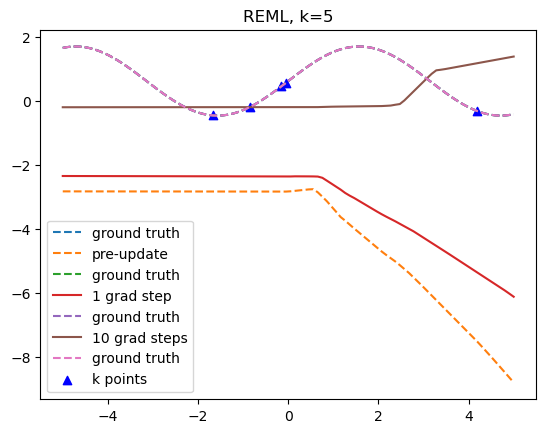

In [244]:
# env with eval task
reml = REML(layer_pool=pool, tasks=tasks)
reml.model.load(path)
env = reml.make_env(eval_task, pool)
reml.model.set_env(env)
reml.env = env
reml.task = eval_task

# ground truth
plt.plot(eval_task.data, eval_task.targets, linestyle='--', label='ground truth')

# pre-update
reml.generate_sine_curve(env=env, args={'linestyle' : '--', 'label': 'pre-update'})

# k points 
plt.scatter(k_pairs[:, 0], k_pairs[:, 1], marker='^', color='b', label='k points')

# train for 1 grad step
reml.env.batch_size = k
obs, _ = reml.env.reset()
for _ in range(1):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' :'1 grad step'})
    
# train for 10 grad steps
obs, _ = reml.env.reset()
for _ in range(10):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' : '10 grad steps'})
plt.title('REML, k=5')

k=10

In [232]:
k = 10
k_pairs = torch.tensor(random.sample(list(zip(eval_task.data, eval_task.targets)), k))
print(len(k_pairs))
print(k_pairs)

10
tensor([[-1.3636, -0.4286],
        [ 2.5758,  1.2073],
        [-0.9596, -0.2562],
        [-0.5556,  0.0587],
        [ 0.1515,  0.7913],
        [-4.8990,  1.6896],
        [ 3.7879, -0.0221],
        [-1.1616, -0.3625],
        [-2.5758,  0.0493],
        [-3.3838,  0.8874]])


[INFO] Reset at 0
[INFO] Reset at 5
[INFO] Reset at 1
[INFO] Reset at 0
[INFO] Reset at 10


Text(0.5, 1.0, 'REML, k=10')

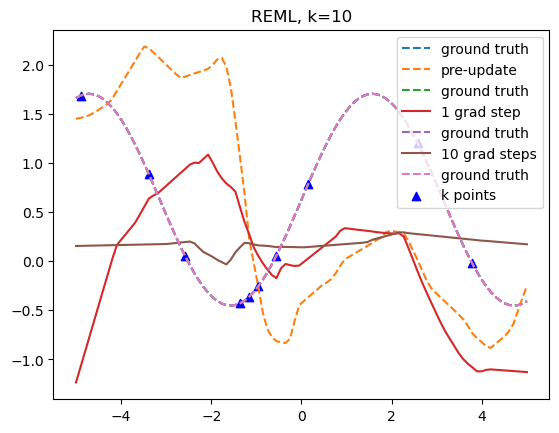

In [234]:
reml = REML(layer_pool=pool, tasks=tasks)
reml.model.load(path)
env = reml.make_env(eval_task)
reml.model.set_env(env)
reml.env = env
reml.task = eval_task

# ground truth
plt.plot(eval_task.data, eval_task.targets, linestyle='--', label='ground truth')

# pre-update
reml.generate_sine_curve(env=env, args={'linestyle' : '--', 'label': 'pre-update'})

# k points 
plt.scatter(k_pairs[:, 0], k_pairs[:, 1], marker='^', color='b', label='k points')

# train for 1 grad step
reml.env.batch_size = k
obs, _ = reml.env.reset()
for _ in range(1):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' :'1 grad step'})
    
# train for 10 grad steps
obs, _ = reml.env.reset()
for _ in range(10):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' : '10 grad steps'})
plt.title('REML, k=10')

In [307]:
k = 5
k_pairs = torch.tensor(random.sample(list(zip(eval_task.data, eval_task.targets)), k))
print(len(k_pairs))
print(k_pairs)

5
tensor([[-3.7879,  3.7157],
        [ 4.6970, -1.1547],
        [-2.6768,  0.5222],
        [ 4.4949, -1.0835],
        [-2.3737, -0.2266]])


[INFO] Reset at 0
[INFO] Reset at 8
[INFO] Reset at 1
[INFO] Reset at 0
[INFO] Reset at 10


Text(0.5, 1.0, 'REML, k=5')

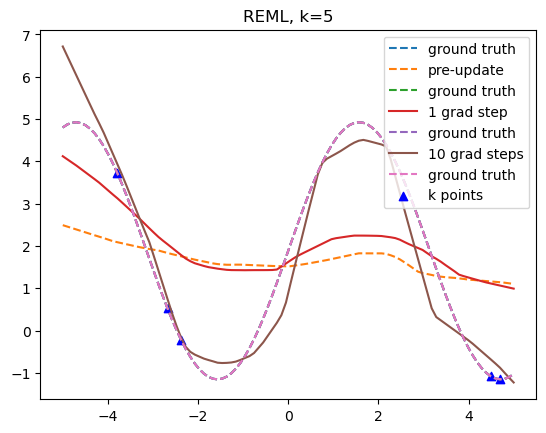

In [309]:
# env with eval task
reml = REML(layer_pool=pool, tasks=tasks)
reml.model.load(path)
env = reml.make_env(eval_task, pool)
reml.model.set_env(env)
reml.env = env
reml.task = eval_task

# ground truth
plt.plot(eval_task.data, eval_task.targets, linestyle='--', label='ground truth')

# pre-update
reml.generate_sine_curve(env=env, args={'linestyle' : '--', 'label': 'pre-update'})

# k points 
plt.scatter(k_pairs[:, 0], k_pairs[:, 1], marker='^', color='b', label='k points')

# train for 1 grad step
reml.env.batch_size = k
obs, _ = reml.env.reset()
for _ in range(1):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' :'1 grad step'})
    
# train for 10 grad steps
obs, _ = reml.env.reset()
for _ in range(10):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' : '10 grad steps'})
plt.title('REML, k=5')